# Task1

In [1]:
import numpy as np
import pandas as pd
import time
from numpy.linalg import norm

In [2]:
def euclidean_distance(x, y):
    return norm(x - y)

def cosine_distance(x, y):
    nx = norm(x)
    ny = norm(y)
    if nx == 0 or ny == 0:
        return 1.0
    return 1 - (np.dot(x, y) / (nx * ny))

def jaccard_distance(x, y):
    numerator = np.minimum(x, y).sum()
    denominator = np.maximum(x, y).sum()
    if denominator == 0:
        return 1.0
    return 1 - numerator / denominator

DIST = {
    "euclidean": euclidean_distance,
    "cosine": cosine_distance,
    "jaccard": jaccard_distance,
}

## Q1

In [ ]:
def kmeans_q1(X, K, metric, max_iter=300):
    dist = DIST[metric]

    N, D = X.shape
    rng = np.random.default_rng(42)
    centroids = X[rng.choice(N, K, replace=False)]

    for _ in range(max_iter):
        labels = np.zeros(N, dtype=int)
        for i in range(N):
            d = [dist(X[i], c) for c in centroids]
            labels[i] = np.argmin(d)

        new_centroids = np.zeros_like(centroids)
        for k in range(K):
            pts = X[labels == k]
            if len(pts) > 0:
                new_centroids[k] = pts.mean(axis=0)
            else:
                new_centroids[k] = centroids[k]

        if np.allclose(new_centroids, centroids):
            break

        centroids = new_centroids

    sse = 0
    for i in range(N):
        c = centroids[labels[i]]
        sse += (dist(X[i], c) ** 2)

    return sse

In [4]:
X = pd.read_csv("data.csv", header=None).values
y = pd.read_csv("label.csv", header=None).values.flatten()
K = len(np.unique(y))
metrics = ["euclidean", "cosine", "jaccard"]

In [5]:
print("=== Q1: Compare SSE of Three Metrics ===")
for metric in metrics:
    print(f"\nRunning {metric}...")
    sse = kmeans_q1(X, K, metric)
    print(f"Final SSE ({metric}): {sse}")


=== Q1: Compare SSE of Three Metrics ===

Running euclidean...
Final SSE (euclidean): 25466905534.0

Running cosine...
Final SSE (cosine): 686.7235414620694

Running jaccard...
Final SSE (jaccard): 3653.2077663232703


## Q2

In [6]:
def compute_accuracy(cluster_labels, true_labels, K):
    predicted = np.zeros_like(true_labels)

    for k in range(K):
        idx = np.where(cluster_labels == k)[0]
        if len(idx) == 0:
            continue
        majority = pd.Series(true_labels[idx]).mode()[0]
        predicted[idx] = majority

    return (predicted == true_labels).mean()

In [7]:
def kmeans_q2(X, K, metric, max_iter=300):
    dist = DIST[metric]
    N, D = X.shape

    rng = np.random.default_rng(42)
    centroids = X[rng.choice(N, K, replace=False)]

    for _ in range(max_iter):
        labels = np.zeros(N, dtype=int)
        for i in range(N):
            d = [dist(X[i], c) for c in centroids]
            labels[i] = np.argmin(d)

        new_centroids = np.zeros_like(centroids)
        for k in range(K):
            pts = X[labels == k]
            if len(pts) > 0:
                new_centroids[k] = pts.mean(axis=0)
            else:
                new_centroids[k] = centroids[k]

        if np.allclose(new_centroids, centroids):
            break

        centroids = new_centroids

    return labels, centroids

In [8]:
print("=== Q2: Compare Accuracy of K-Means Metrics ===")

for metric in metrics:
    print(f"\nRunning {metric}...")
    cluster_labels, centroids = kmeans_q2(X, K, metric)
    acc = compute_accuracy(cluster_labels, y, K)
    print(f"Accuracy ({metric}): {acc:.4f}")

=== Q2: Compare Accuracy of K-Means Metrics ===

Running euclidean...
Accuracy (euclidean): 0.6417

Running cosine...
Accuracy (cosine): 0.6317

Running jaccard...
Accuracy (jaccard): 0.6046


## Q3

In [ ]:
def kmeans_q3(X, K, metric, max_iter=500):
    dist = DIST[metric]
    N, D = X.shape

    rng = np.random.default_rng(42)
    centroids = X[rng.choice(N, K, replace=False)]

    prev_sse = np.inf

    start = time.time()

    for it in range(max_iter):
        labels = np.zeros(N, dtype=int)
        for i in range(N):
            d = [dist(X[i], c) for c in centroids]
            labels[i] = np.argmin(d)

        new_centroids = np.zeros_like(centroids)
        for k in range(K):
            pts = X[labels == k]
            if len(pts) > 0:
                new_centroids[k] = pts.mean(axis=0)
            else:
                new_centroids[k] = centroids[k]

        sse = 0.0
        for i in range(N):
            c = new_centroids[labels[i]]
            sse += (dist(X[i], c) ** 2)

        if np.allclose(new_centroids, centroids):
            stop_reason = "centroid-stable"
            break

        if sse > prev_sse:
            stop_reason = "sse-increase"
            break

        prev_sse = sse
        centroids = new_centroids

    else:
        stop_reason = "max-iteration"

    end = time.time()

    return it + 1, end - start, stop_reason

In [10]:
print("=== Q3: Iteration & Time Comparison ===")

for metric in metrics:
    print(f"\nRunning {metric}...")
    iterations, used_time, stop_reason = kmeans_q3(X, K, metric)

    print(f"Iterations: {iterations}")
    print(f"Time used: {used_time:.4f} sec")
    print(f"Stop reason: {stop_reason}")

=== Q3: Iteration & Time Comparison ===

Running euclidean...
Iterations: 37
Time used: 22.5965 sec
Stop reason: centroid-stable

Running cosine...
Iterations: 26
Time used: 25.5527 sec
Stop reason: sse-increase

Running jaccard...
Iterations: 13
Time used: 9.5378 sec
Stop reason: sse-increase


## Q4

In [ ]:
def kmeans_q4(X, K, metric, stop_type, max_iter=100):
    dist = DIST[metric]
    N, D = X.shape

    rng = np.random.default_rng(42)
    centroids = X[rng.choice(N, K, replace=False)]

    prev_sse = np.inf

    for it in range(max_iter):
        labels = np.zeros(N, dtype=int)
        for i in range(N):
            d = [dist(X[i], c) for c in centroids]
            labels[i] = np.argmin(d)

        new_centroids = np.zeros_like(centroids)
        for k in range(K):
            pts = X[labels == k]
            if len(pts) > 0:
                new_centroids[k] = pts.mean(axis=0)
            else:
                new_centroids[k] = centroids[k]

        sse = 0.0
        for i in range(N):
            c = new_centroids[labels[i]]
            sse += (dist(X[i], c) ** 2)

        if stop_type == "centroid":
            if np.allclose(new_centroids, centroids):
                break

        elif stop_type == "sse":
            if sse > prev_sse:
                break

        prev_sse = sse
        centroids = new_centroids

    return sse

In [12]:
print("=== Q4: Compare SSE under 3 Stopping Conditions ===\n")
stops = ["centroid", "sse", "max"]

for metric in metrics:
    print(f"\n---- {metric.upper()} ----")
    for stop in stops:
        sse = kmeans_q4(X, K, metric, stop, max_iter=100)
        print(f"Stop={stop:8s}  SSE={sse}")

=== Q4: Compare SSE under 3 Stopping Conditions ===


---- EUCLIDEAN ----
Stop=centroid  SSE=25466905534.0
Stop=sse       SSE=25466905534.0
Stop=max       SSE=25466905534.0

---- COSINE ----
Stop=centroid  SSE=686.7235414620694
Stop=sse       SSE=686.7309954392545
Stop=max       SSE=686.7235414620694

---- JACCARD ----
Stop=centroid  SSE=3653.759229739134
Stop=sse       SSE=3668.162418965095
Stop=max       SSE=3653.759229739134


# Task 2

In [13]:
from surprise import Dataset, Reader
from surprise import KNNBasic, SVD
from surprise.model_selection import cross_validate

file_path = "ratings_small.csv"

df = pd.read_csv(file_path)

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df[["userId", "movieId", "rating"]], reader)

## c

In [14]:
def PMF():
    return SVD(biased=False)

# User-based Collaborative Filtering
def UserCF():
    return KNNBasic(sim_options={"name": "cosine", "user_based": True})

# Item-based Collaborative Filtering
def ItemCF():
    return KNNBasic(sim_options={"name": "cosine", "user_based": False})

In [15]:
def evaluate(model, name):
    cv_result = cross_validate(
        model, data,
        measures=["RMSE", "MAE"],
        cv=5,
        verbose=False
    )
    mean_rmse = cv_result['test_rmse'].mean()
    mean_mae = cv_result['test_mae'].mean()

    print(f"=== {name} ===")
    print(f"Average RMSE: {mean_rmse:.4f}")
    print(f"Average MAE : {mean_mae:.4f}\n")

In [16]:
print("\n### Task 2(c): Average MAE & RMSE under 5-Folds ###\n")

evaluate(PMF(), "PMF")
evaluate(UserCF(), "User-based Collaborative Filtering")
evaluate(ItemCF(), "Item-based Collaborative Filtering")


### Task 2(c): Average MAE & RMSE under 5-Folds ###

=== PMF ===
Average RMSE: 1.0151
Average MAE : 0.7822

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
=== User-based Collaborative Filtering ===
Average RMSE: 0.9943
Average MAE : 0.7683

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
=== Item-based Collaborative Filtering ===
Av

## e

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd sim

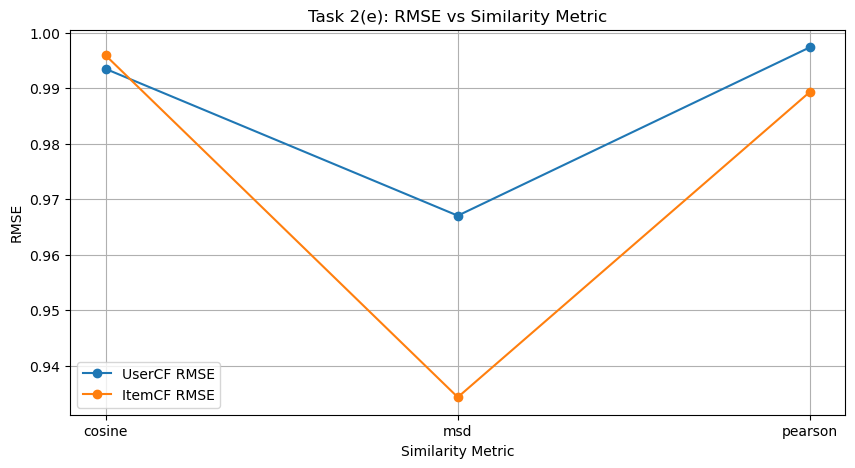

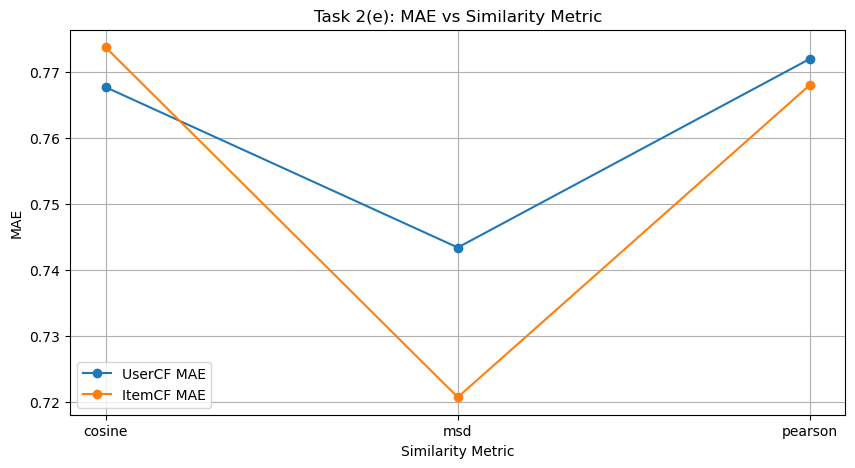

In [17]:
import matplotlib.pyplot as plt

# Similarity metrics
similarities = ["cosine", "msd", "pearson"]

rmse_user = []
rmse_item = []

mae_user = []
mae_item = []

# Evaluate each similarity for UserCF and ItemCF
for sim in similarities:
    algo_user = KNNBasic(sim_options={"name": sim, "user_based": True})
    algo_item = KNNBasic(sim_options={"name": sim, "user_based": False})

    cv_user = cross_validate(algo_user, data, measures=["RMSE", "MAE"], cv=5, verbose=False)
    cv_item = cross_validate(algo_item, data, measures=["RMSE", "MAE"], cv=5, verbose=False)

    rmse_user.append(cv_user["test_rmse"].mean())
    rmse_item.append(cv_item["test_rmse"].mean())

    mae_user.append(cv_user["test_mae"].mean())
    mae_item.append(cv_item["test_mae"].mean())

# ===== Plot RMSE =====
plt.figure(figsize=(10, 5))
plt.plot(similarities, rmse_user, marker="o", label="UserCF RMSE")
plt.plot(similarities, rmse_item, marker="o", label="ItemCF RMSE")
plt.xlabel("Similarity Metric")
plt.ylabel("RMSE")
plt.title("Task 2(e): RMSE vs Similarity Metric")
plt.legend()
plt.grid(True)
plt.show()

# ===== Plot MAE =====
plt.figure(figsize=(10, 5))
plt.plot(similarities, mae_user, marker="o", label="UserCF MAE")
plt.plot(similarities, mae_item, marker="o", label="ItemCF MAE")
plt.xlabel("Similarity Metric")
plt.ylabel("MAE")
plt.title("Task 2(e): MAE vs Similarity Metric")
plt.legend()
plt.grid(True)
plt.show()


## f

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

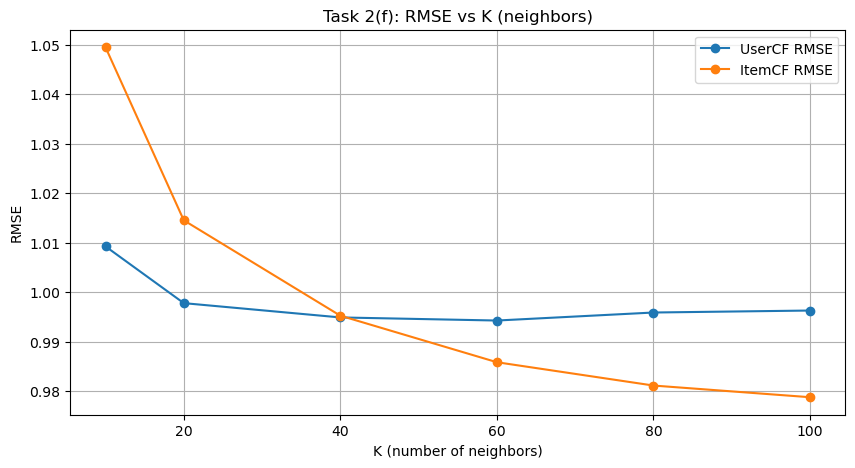

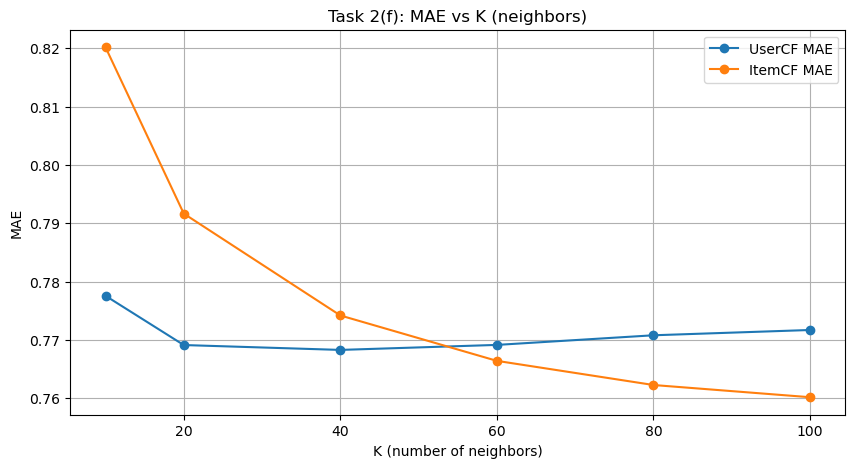

In [18]:
k_values = [10, 20, 40, 60, 80, 100]

rmse_user_k = []
rmse_item_k = []

mae_user_k = []
mae_item_k = []

for k in k_values:
    algo_user = KNNBasic(k=k, sim_options={"name": "cosine", "user_based": True})
    algo_item = KNNBasic(k=k, sim_options={"name": "cosine", "user_based": False})

    cv_user = cross_validate(algo_user, data, measures=["RMSE", "MAE"], cv=5, verbose=False)
    cv_item = cross_validate(algo_item, data, measures=["RMSE", "MAE"], cv=5, verbose=False)

    rmse_user_k.append(cv_user["test_rmse"].mean())
    rmse_item_k.append(cv_item["test_rmse"].mean())

    
    mae_user_k.append(cv_user["test_mae"].mean())
    mae_item_k.append(cv_item["test_mae"].mean())

# ===== Plotting =====
plt.figure(figsize=(10, 5))
plt.plot(k_values, rmse_user_k, marker="o", label="UserCF RMSE")
plt.plot(k_values, rmse_item_k, marker="o", label="ItemCF RMSE")
plt.xlabel("K (number of neighbors)")
plt.ylabel("RMSE")
plt.title("Task 2(f): RMSE vs K (neighbors)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(k_values, mae_user_k, marker="o", label="UserCF MAE")
plt.plot(k_values, mae_item_k, marker="o", label="ItemCF MAE")
plt.xlabel("K (number of neighbors)")
plt.ylabel("MAE")
plt.title("Task 2(f): MAE vs K (neighbors)")
plt.legend()
plt.grid(True)
plt.show()
